<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: If Fourier knew about neural networks?
by Fayyaz Minhas

This tutorial explores how Fourier transform can be viewed as a neural network. By treating the decomposition and reconstruction of signals as a learning process, we employ a neural network to approximate the discrete Fourier Transform (DFT), enabling the analysis and synthesis of signals in terms of their sinusoidal components.

Theoretical Background
Discrete Fourier Transform (DFT)
The DFT is a mathematical technique used to transform a discrete signal from the time domain into the frequency domain, decomposing it into a series of sinusoids of varying magnitudes and phases. The DFT of a discrete signal
�
[
�
]
x[n] is given by:

�
[
�
]
=
∑
�
=
0
�
−
1
�
[
�
]
⋅
�
−
�
2
�
�
�
�
X[k]=∑
n=0
N−1
​
 x[n]⋅e
−j
N
2π
​
 kn


where:

�
[
�
]
X[k] is the DFT of the signal
�
[
�
]
x[n],
�
N is the number of samples in
�
[
�
]
x[n],
�
k represents the index in the frequency domain, and
�
n represents the index in the time domain.
Signal Reconstruction
The inverse DFT (IDFT) allows for the reconstruction of the original signal from its frequency components, utilizing the amplitudes and phases obtained through the DFT:

�
[
�
]
=
1
�
∑
�
=
0
�
−
1
�
[
�
]
⋅
�
�
2
�
�
�
�
x[n]=
N
1
​
 ∑
k=0
N−1
​
 X[k]⋅e
j
N
2π
​
 kn


Neural Network Approach
We employ a neural network to learn the weight matrix that can decompose and reconstruct the signal, mimicking the DFT and IDFT processes. This approach enables the neural network to capture the frequency components of the signal and reconstruct it from these components.

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


class MatrixGenerator(nn.Module):
    def __init__(self, M, N):
        super(MatrixGenerator, self).__init__()
        # Define the two MxN learnable matrices
        #self.matrix0 = nn.Parameter(0.01*torch.randn(N, 2*N))
        self.matrix1 = nn.Parameter(0.01*torch.randn(N, M))
        self.matrix2 = nn.Parameter(0.01*torch.randn(M, 2*N))

    def forward(self,x = None):
        transformed_matrix1 = self.matrix1
        transformed_matrix2 = self.matrix2
        output_matrix = F.tanh(transformed_matrix1@transformed_matrix2)
        #output_matrix = self.matrix0
        return output_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters

N = 300
M = 200
# Convert arrays to tensors, move them to the specified device, and perform operations
tvals = torch.arange(N).view(-1, 1).float().to(device)  # Reshape and convert to float for division
freqs = torch.arange(N).view(1, -1).float().to(device)  # Reshape and convert to float for division
tf = 2 * torch.pi * tvals * freqs / N  # tf_(j,k) = 2*pi*(t_j)*(f_k) = 2pi(j)(k)/N (matrix of size NxN)
generator = MatrixGenerator(M=M, N=N).to(device)
#generator_real = MatrixGenerator(M=M, N=N).to(device)
#generator_imag = MatrixGenerator(M=M, N=N).to(device)
#optimizer = torch.optim.SGD(list(generator_real.parameters()) + list(generator_imag.parameters()), lr=0.01)
optimizer = torch.optim.SGD(generator.parameters(), lr=0.05)
losses = []
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    x = (torch.randn(1, N)).to(device)
    # Generate W_real and W_imag matrices
    #gen_input = torch.randn(1, M).to(device)
    W = generator()
    W_real,W_imag = W[:,:N],W[:,N:]
    #W_real = generator_real()
    #W_imag = generator_imag()
    # Forward pass using W_real and W_imag from separate generators
    y_real = torch.mm(x, W_real)
    y_imag = torch.mm(x, W_imag)
    amplitudes = torch.sqrt(y_real**2 + y_imag**2) #A_k = sqrt((x*W^{imag}_k)**2+(x*W^{real}_k)**2) amplitude of the k-th sinusoid

    phases = torch.atan2(y_imag, y_real) # \phi_k = atan2(x*W^{imag}_k,x*W^{real}_k) phase of the k-th sinusoid
    sinusoids = amplitudes * torch.sin(tf + phases) # S^{k}[j] = A_k sin(2*pi*j*k/N + \phi_k) #each col is a sinusoid
    reconstructed_signal = (1/N)*torch.sum(sinusoids, axis=1) # x[j] = (1/N)*\sum_{k=0}^{N-1} S^{k}[j] = (1/N)*\sum_{k=0}^{N-1} A_k sin(2*pi*j*k/N + \phi_k)


    loss = torch.sum((x - reconstructed_signal) ** 2)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())


 17%|█▋        | 1722/10000 [00:16<01:04, 128.51it/s]

Reduction: 1.0


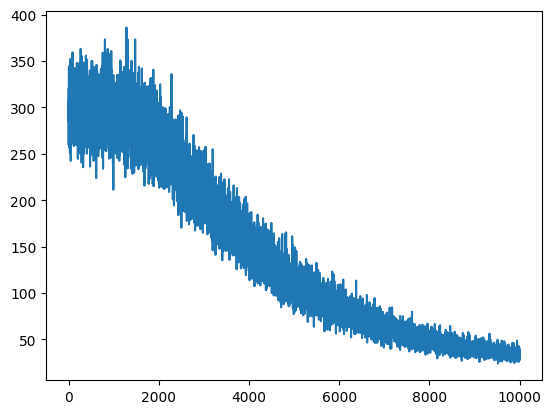

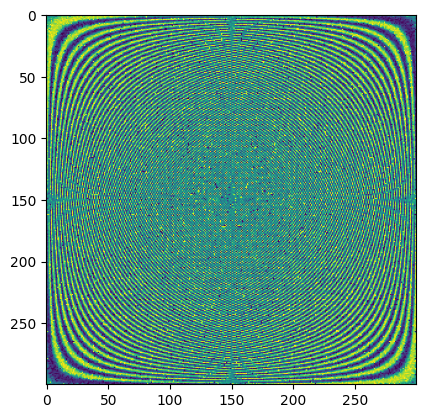

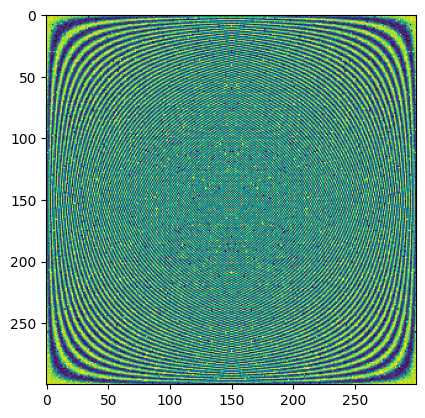

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
#total_params = count_parameters(generator_real)+count_parameters(generator_imag)
total_params = count_parameters(generator)

print(f"Reduction: {total_params/(N*N*2)}")

import matplotlib.pyplot as plt
plt.plot(losses);plt.show()
Wr = W_real.detach().cpu().numpy()
Wi = W_imag.detach().cpu().numpy()
plt.imshow(Wr);plt.show()
plt.imshow(Wi)
